In [2]:
import torch
import pickle
import numpy as np
from evaluation import *
from functions import *
from Models.UNet import *
from torch.utils.data import TensorDataset
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# Loading dataset
x = pickle.load(open("./Xs.pkl", "rb"))
y = pickle.load(open("./Ys.pkl", "rb"))

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
x = torch.FloatTensor(x)
y = torch.FloatTensor(y)

In [5]:
# Shifting dimensions
x, y = x.permute(0, 3, 1, 2), y.permute(0, 3, 1, 2)
# Removing channel 1 in input channels
x = torch.cat((x[:, 0:1, :, :], x[:, 2:, :, :]), dim=1)
# Adding binary channel to describe the shape of object
bin_channel = torch.isnan(x[:, 2:, :, :]).type(torch.float)
x = bin_channel
print(torch.sum(bin_channel))

tensor(467592.)


In [6]:
# Removing NaN values
x[torch.isnan(x)] = 0
y[torch.isnan(y)] = 0

In [7]:
# Computing Root Mean Square of features to equally prioritize each feature in loss function
features_mse = torch.sqrt(torch.mean(y.permute(0, 2, 3, 1).view(-1, y.shape[1]) ** 2, dim=0)).view(1, -1, 1, 1).to(device)
print(features_mse)

tensor([[[[0.1156]],

         [[0.0173]],

         [[0.0135]]]], device='cuda:0')


In [8]:
print(x.shape)
print(y.shape)

torch.Size([961, 1, 172, 79])
torch.Size([961, 3, 172, 79])


In [9]:
# Shuffling the dataset
x, y = shuffle_tensors(x, y)

In [10]:
# Spliting dataset into 70% train and 30% test
train_data, test_data = split_tensors(x, y, ratio=0.7)
train_dataset, test_dataset = TensorDataset(*train_data), TensorDataset(*test_data)

In [11]:
# Creating model
model = UNet(1, 3, filters=[16,32,8], kernel_size=7, layers=3,
                    batch_norm=False, weight_norm=False)
model

UNet(
  (encoders): Sequential(
    (0): Sequential(
      (0): Sequential(
        (0): Conv2d(1, 16, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
        (1): ReLU()
      )
      (1): Sequential(
        (0): Conv2d(16, 16, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
        (1): ReLU()
      )
      (2): Sequential(
        (0): Conv2d(16, 16, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
        (1): ReLU()
      )
    )
    (1): Sequential(
      (0): Sequential(
        (0): Conv2d(16, 32, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
        (1): ReLU()
      )
      (1): Sequential(
        (0): Conv2d(32, 32, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
        (1): ReLU()
      )
      (2): Sequential(
        (0): Conv2d(32, 32, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
        (1): ReLU()
      )
    )
    (2): Sequential(
      (0): Sequential(
        (0): Conv2d(32, 8, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
        (1): 

In [12]:
# Initializing weights
# initialize(model)

In [13]:
# Initializing optimizer
lr = 1e-4
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

In [14]:
# Defining loss function
def loss_func(model, batch):
    x, y = batch
    output = model(x)
    loss = ((output - y) ** 2) / features_mse
    return torch.sum(loss), output

In [15]:
# Selecting sample from test dataset for visualization
sample_x, sample_y = test_data[0][0:1].to(device), test_data[1][0:1].to(device)

In [16]:
# Computing output and error for test sample
def compute_error(model, sample_x, sample_y):
    with torch.no_grad():
        out_y = model(sample_x)
        error = torch.abs(sample_y - out_y)
        return out_y, error

In [17]:
# Visualize sample
def visualize(sample_y, out_y, error):
    plt.figure()
    fig = plt.gcf()
    fig.set_size_inches(15, 10)
    plt.subplot(3, 3, 1)
    plt.title('CFD', fontsize=18) 
    plt.imshow(np.transpose(sample_y[0,0,:,:]) , cmap='jet')
    plt.colorbar(orientation='horizontal')
    plt.ylabel('Ux', fontsize=18)
    plt.subplot(3, 3, 2)
    plt.title('CNN', fontsize=18) 
    plt.imshow(np.transpose(out_y[0,0,:,:]), cmap='jet')
    plt.colorbar(orientation='horizontal')
    plt.subplot(3, 3, 3)
    plt.title('Error', fontsize=18)
    plt.imshow(np.transpose(error[0,0,:,:]), cmap='jet')
    plt.colorbar(orientation='horizontal')

    plt.subplot(3, 3, 4)
    plt.imshow(np.transpose(sample_y[0,1,:,:]) , cmap='jet')
    plt.colorbar(orientation='horizontal')
    plt.ylabel('Uy', fontsize=18)
    plt.subplot(3, 3, 5)
    plt.imshow(np.transpose(out_y[0,1,:,:]), cmap='jet')
    plt.colorbar(orientation='horizontal')
    plt.subplot(3, 3, 6)
    plt.imshow(np.transpose(error[0,1,:,:]), cmap='jet')
    plt.colorbar(orientation='horizontal')

    plt.subplot(3, 3, 7)
    plt.imshow(np.transpose(sample_y[0,2,:,:]) , cmap='jet')
    plt.colorbar(orientation='horizontal')
    plt.ylabel('p', fontsize=18)
    plt.subplot(3, 3, 8)
    plt.imshow(np.transpose(out_y[0,2,:,:]), cmap='jet')
    plt.colorbar(orientation='horizontal')
    plt.subplot(3, 3, 9)
    plt.imshow(np.transpose(error[0,2,:,:]), cmap='jet')
    plt.colorbar(orientation='horizontal')
    plt.tight_layout()
    plt.show()

In [18]:
# Visualize after N epochs
def after_epoch(scope):
    epoch = scope["epoch"]
    best_model = scope["best_model"]
    if epoch % 10 == 0:
        out_y, error = compute_error(best_model, sample_x, sample_y)
        visualize(sample_y.cpu().numpy(), out_y.cpu().numpy(), error.cpu().numpy())

Epoch #1
	Train Loss = 862427.564453125
	Train Total MSE = 100.29713294619606
	Train Ux MSE = 92.68295724051339
	Train Uy MSE = 5.089502663839431
	Train p MSE = 2.524672269821167
	Validation Loss = 182682.5487060547
	Validation Total MSE = 37.998437663675595
	Validation Ux MSE = 32.44800274594845
	Validation Uy MSE = 3.6943377252268546
	Validation p MSE = 1.8560963782472182
Model saved!
Epoch #2
	Train Loss = 423166.5732421875
	Train Total MSE = 35.67250987461635
	Train Ux MSE = 29.934213002522785
	Train Uy MSE = 3.3698066416240873
	Train p MSE = 2.368490071523757
	Validation Loss = 144966.3387451172
	Validation Total MSE = 31.561441137716432
	Validation Ux MSE = 27.38271710616907
	Validation Uy MSE = 2.7711134352898514
	Validation p MSE = 1.4076096805321716
Model saved!
Epoch #3
	Train Loss = 353963.0400390625
	Train Total MSE = 31.25982057480585
	Train Ux MSE = 26.729985282534646
	Train Uy MSE = 2.4892461526961553
	Train p MSE = 2.0405894205683754
	Validation Loss = 121156.1656799316

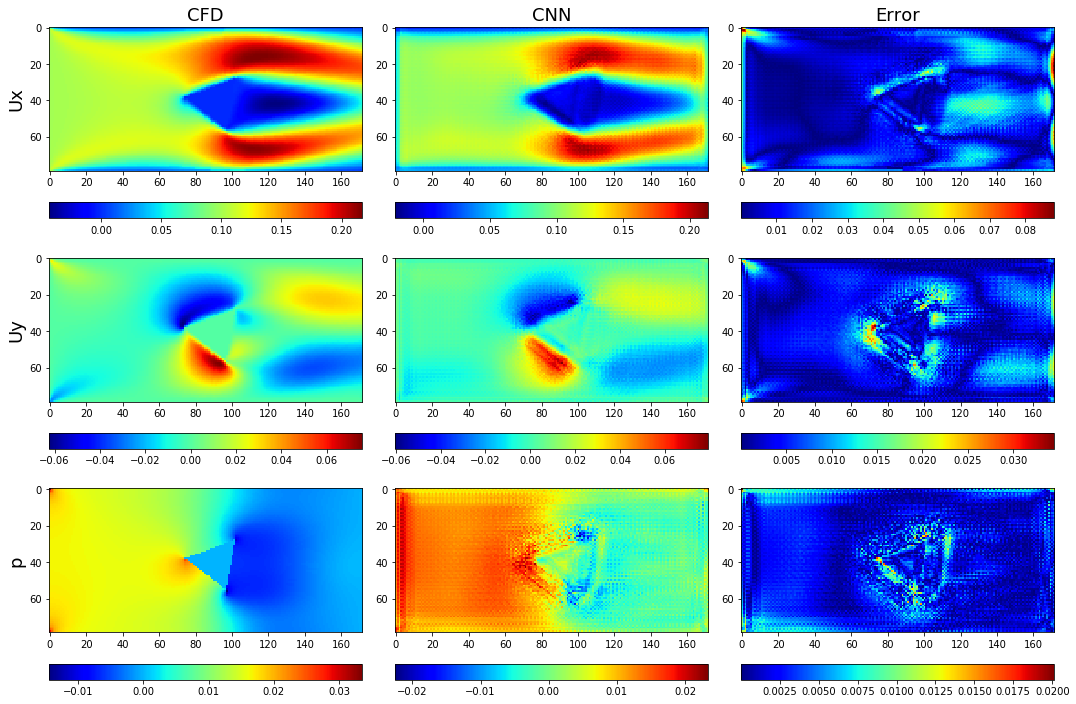

Epoch #11
	Train Loss = 103254.640625
	Train Total MSE = 4.724011750448318
	Train Ux MSE = 2.8840457030705045
	Train Uy MSE = 0.48774471169426326
	Train p MSE = 1.352221246276583
	Validation Loss = 24995.21450805664
	Validation Total MSE = 3.4085974322058337
	Validation Ux MSE = 2.450560048377225
	Validation Uy MSE = 0.3580661343868216
	Validation p MSE = 0.5999711491554254
Model saved!
Epoch #12
	Train Loss = 100967.79479980469
	Train Total MSE = 4.507930710202172
	Train Ux MSE = 2.69494861080533
	Train Uy MSE = 0.47334261735280353
	Train p MSE = 1.3396394564991905
	Validation Loss = 24267.66120147705
	Validation Total MSE = 3.219129645288197
	Validation Ux MSE = 2.2790403374338646
	Validation Uy MSE = 0.33992357825325437
	Validation p MSE = 0.6001656745080305
Model saved!
Epoch #13
	Train Loss = 99076.63220214844
	Train Total MSE = 4.342755414190746
	Train Ux MSE = 2.55919767561413
	Train Uy MSE = 0.44026229069346473
	Train p MSE = 1.3432955245176952
	Validation Loss = 23728.45256423

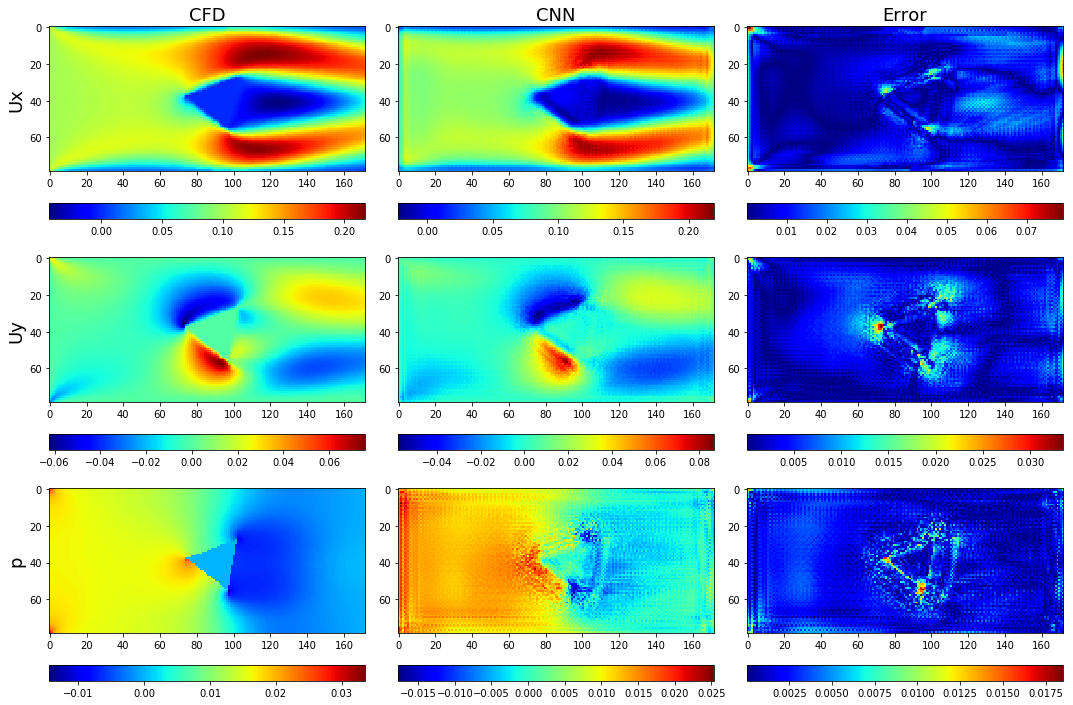

Epoch #21
	Train Loss = 89100.34033203125
	Train Total MSE = 3.4388628403345742
	Train Ux MSE = 1.7849708568482172
	Train Uy MSE = 0.35023331216403414
	Train p MSE = 1.303658589720726
	Validation Loss = 19656.397665023804
	Validation Total MSE = 2.266857196715464
	Validation Ux MSE = 1.4675828140087193
	Validation Uy MSE = 0.2474458204730572
	Validation p MSE = 0.5518285637289595
Model saved!
Epoch #22
	Train Loss = 88761.39080810547
	Train Total MSE = 3.3901296229589555
	Train Ux MSE = 1.7410318851470947
	Train Uy MSE = 0.3362055186714445
	Train p MSE = 1.3128922283649445
	Validation Loss = 19272.957847595215
	Validation Total MSE = 2.181458907762613
	Validation Ux MSE = 1.3944333812357232
	Validation Uy MSE = 0.23436244391549418
	Validation p MSE = 0.552663045551847
Model saved!
Epoch #23
	Train Loss = 87953.58221435547
	Train Total MSE = 3.3160262334914434
	Train Ux MSE = 1.6737151940663655
	Train Uy MSE = 0.34318605065345764
	Train p MSE = 1.2991250299272084
	Validation Loss = 2077

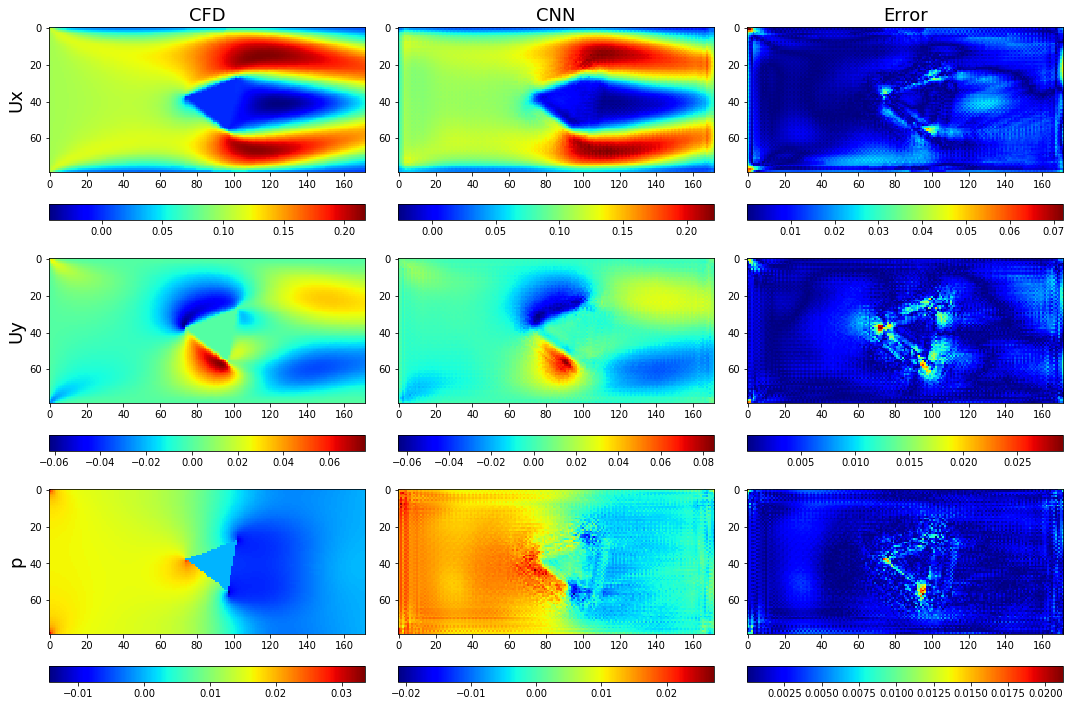

Epoch #31
	Train Loss = 85085.26171875
	Train Total MSE = 3.071345783415295
	Train Ux MSE = 1.4717519141378856
	Train Uy MSE = 0.3036562885556902
	Train p MSE = 1.2959376215225173
	Validation Loss = 18029.78984451294
	Validation Total MSE = 1.906610449292668
	Validation Ux MSE = 1.153855776498062
	Validation Uy MSE = 0.21461938971260427
	Validation p MSE = 0.5381352211828875
Model saved!
Epoch #32
	Train Loss = 85697.04901123047
	Train Total MSE = 3.0728039627983454
	Train Ux MSE = 1.458222094036284
	Train Uy MSE = 0.3089022203570321
	Train p MSE = 1.3056797035748051
	Validation Loss = 18179.835698127747
	Validation Total MSE = 1.8945285783094519
	Validation Ux MSE = 1.1299520250422732
	Validation Uy MSE = 0.22386479692269362
	Validation p MSE = 0.5407118167225465
Epoch #33
	Train Loss = 84214.2748413086
	Train Total MSE = 2.988380792595091
	Train Ux MSE = 1.3972590168317158
	Train Uy MSE = 0.30499254663785297
	Train p MSE = 1.2861291604737441
	Validation Loss = 18047.57132911682
	Vali

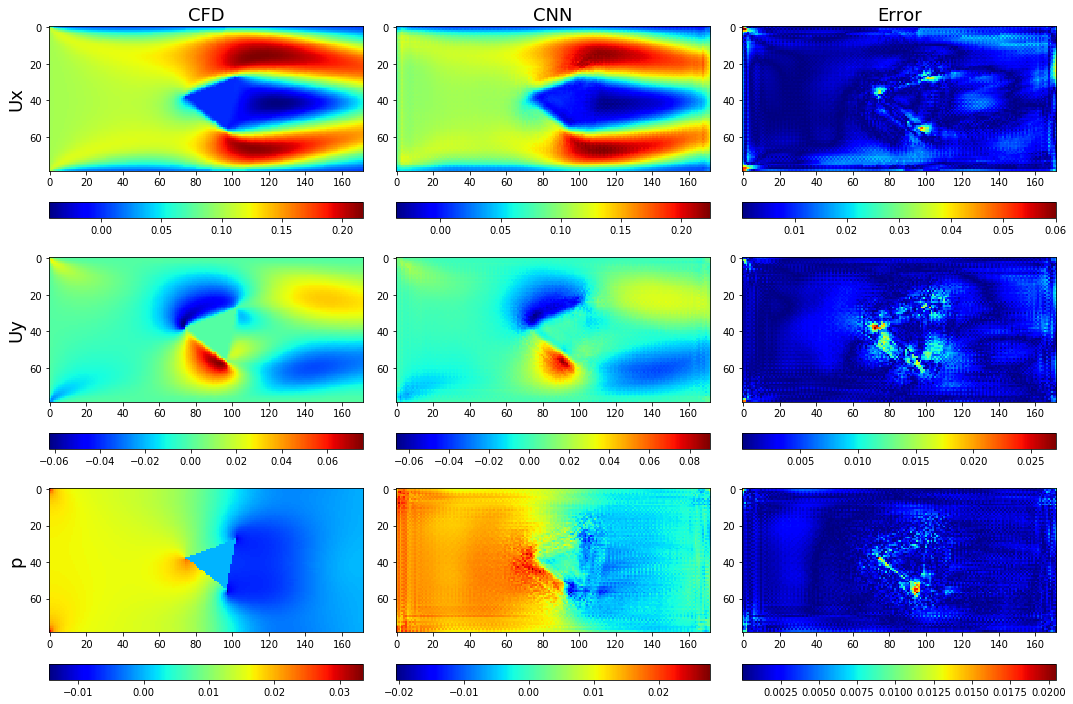

Epoch #41
	Train Loss = 83279.49206542969
	Train Total MSE = 2.9099260369936624
	Train Ux MSE = 1.3322560900733584
	Train Uy MSE = 0.29464804842358544
	Train p MSE = 1.283021870468344
	Validation Loss = 17178.016426086426
	Validation Total MSE = 1.7570277145164648
	Validation Ux MSE = 1.0360702523723193
	Validation Uy MSE = 0.18831509055253956
	Validation p MSE = 0.5326423958511088
Model saved!
Epoch #42
	Train Loss = 83444.85266113281
	Train Total MSE = 2.9384837434405373
	Train Ux MSE = 1.3608121985480899
	Train Uy MSE = 0.2947084250904265
	Train p MSE = 1.282963078469038
	Validation Loss = 17850.660305023193
	Validation Total MSE = 1.855843178953679
	Validation Ux MSE = 1.1095534525940576
	Validation Uy MSE = 0.1998719848872881
	Validation p MSE = 0.5464177792472926
Epoch #43
	Train Loss = 81852.19647216797
	Train Total MSE = 2.7963405506951466
	Train Ux MSE = 1.2395706460589455
	Train Uy MSE = 0.2806652677910669
	Train p MSE = 1.276104611122892
	Validation Loss = 17018.669565200806

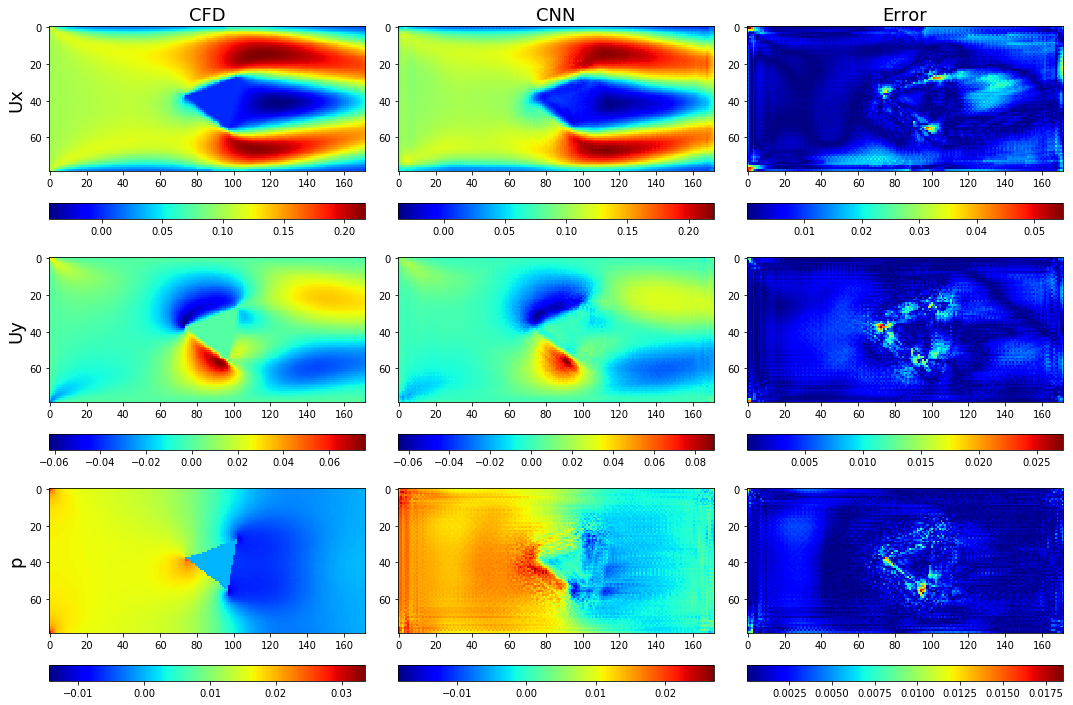

Epoch #51
	Train Loss = 79874.16418457031
	Train Total MSE = 2.6832147240638733
	Train Ux MSE = 1.1593482267288935
	Train Uy MSE = 0.2688010058232716
	Train p MSE = 1.2550655009136313
	Validation Loss = 16645.394649505615
	Validation Total MSE = 1.5885128772794994
	Validation Ux MSE = 0.8796014043286597
	Validation Uy MSE = 0.16378673860822582
	Validation p MSE = 0.5451247714086078
Epoch #52
	Train Loss = 79087.96011352539
	Train Total MSE = 2.626264901388259
	Train Ux MSE = 1.1162755418391455
	Train Uy MSE = 0.2546430627504985
	Train p MSE = 1.2553462595457123
	Validation Loss = 16662.06293487549
	Validation Total MSE = 1.6214460959484007
	Validation Ux MSE = 0.9143066245379332
	Validation Uy MSE = 0.17048277512553653
	Validation p MSE = 0.5366567276598673
Epoch #53
	Train Loss = 79823.19921875
	Train Total MSE = 2.653310565721421
	Train Ux MSE = 1.1279130578041077
	Train Uy MSE = 0.26383030308144434
	Train p MSE = 1.2615671854998385
	Validation Loss = 16294.441473007202
	Validation T

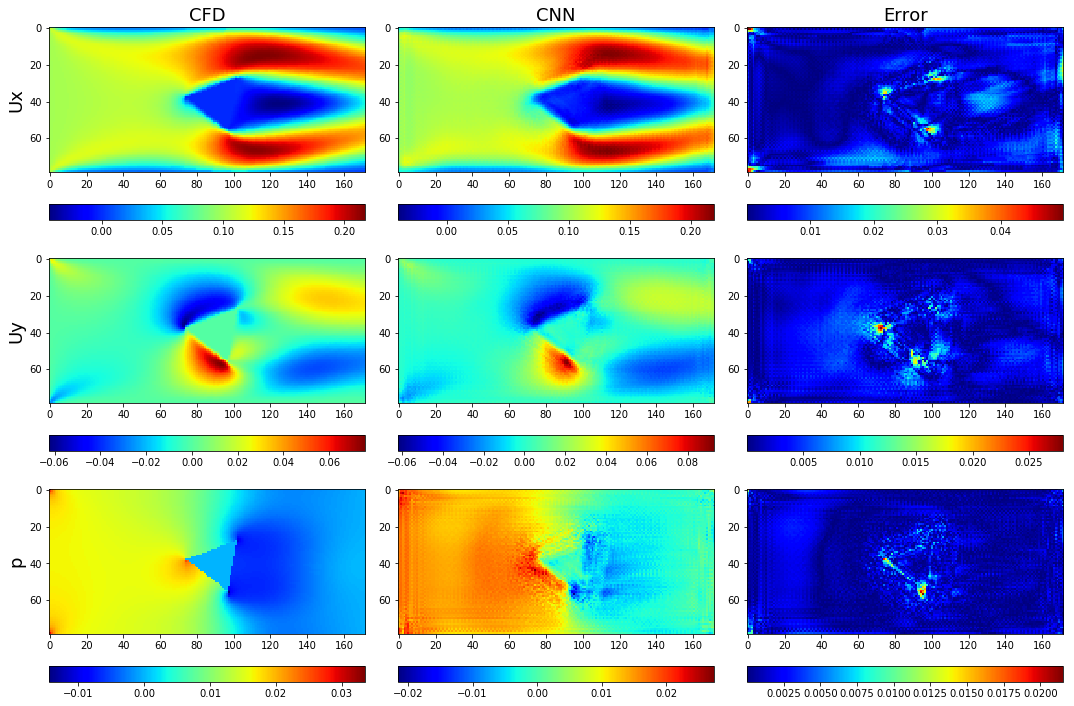

Epoch #61
	Train Loss = 81486.68518066406
	Train Total MSE = 2.776334365208944
	Train Ux MSE = 1.2270287757828122
	Train Uy MSE = 0.27344393233458203
	Train p MSE = 1.2758616643647354
	Validation Loss = 17646.03289604187
	Validation Total MSE = 1.8925465943491582
	Validation Ux MSE = 1.1637373279947723
	Validation Uy MSE = 0.19244564489612942
	Validation p MSE = 0.5363635540421033
Epoch #62
	Train Loss = 80728.01055908203
	Train Total MSE = 2.7807770399820235
	Train Ux MSE = 1.250866032782055
	Train Uy MSE = 0.2669978475286847
	Train p MSE = 1.2629131625096004
	Validation Loss = 16012.8325881958
	Validation Total MSE = 1.5403954757951122
	Validation Ux MSE = 0.8614571521438942
	Validation Uy MSE = 0.1519210786916393
	Validation p MSE = 0.5270172379988287
Epoch #63
	Train Loss = 78147.57690429688
	Train Total MSE = 2.5664009735697793
	Train Ux MSE = 1.071815862542107
	Train Uy MSE = 0.2467689219684828
	Train p MSE = 1.2478161010713804
	Validation Loss = 15649.242421150208
	Validation To

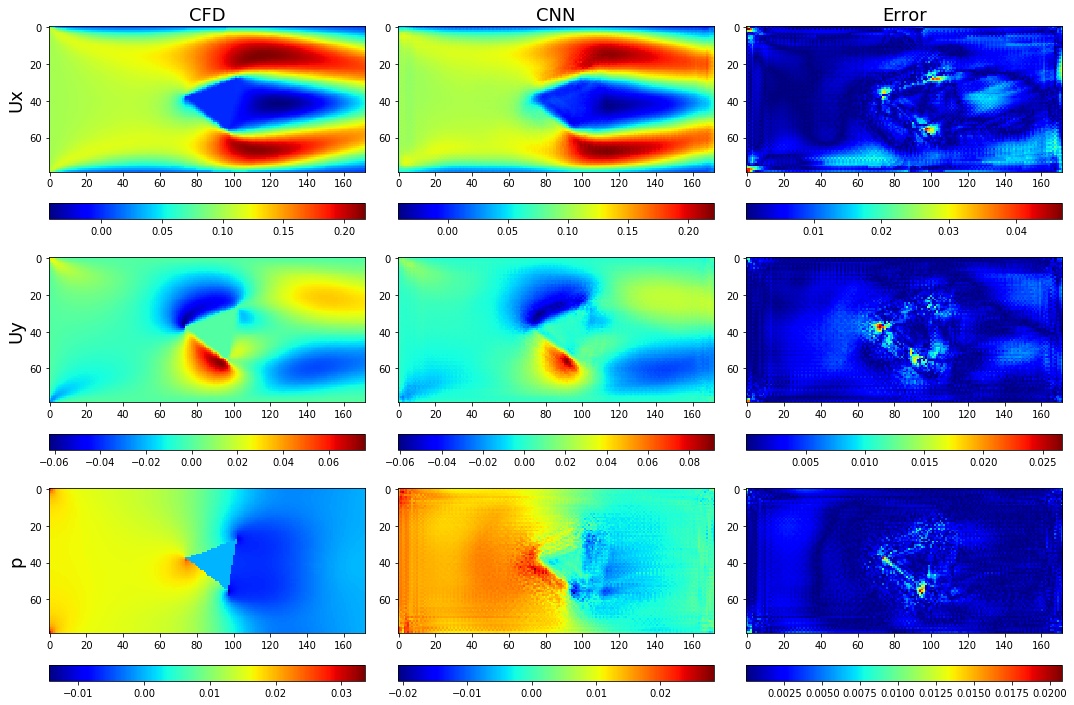

Epoch #71
	Train Loss = 78199.1586303711
	Train Total MSE = 2.5905702028955733
	Train Ux MSE = 1.0984105212347848
	Train Uy MSE = 0.2451330284987177
	Train p MSE = 1.2470267674043065
	Validation Loss = 15888.14752292633
	Validation Total MSE = 1.5007111499260042
	Validation Ux MSE = 0.8192931776640737
	Validation Uy MSE = 0.16710667752992736
	Validation p MSE = 0.5143112951831628
Epoch #72
	Train Loss = 79858.2082824707
	Train Total MSE = 2.678392055488768
	Train Ux MSE = 1.1551108558972676
	Train Uy MSE = 0.2653898685460999
	Train p MSE = 1.2578913590737753
	Validation Loss = 18016.287675857544
	Validation Total MSE = 1.803071250552537
	Validation Ux MSE = 1.047914288035726
	Validation Uy MSE = 0.17284221885319812
	Validation p MSE = 0.5823147609881464
Epoch #73
	Train Loss = 79693.94186401367
	Train Total MSE = 2.662721963155837
	Train Ux MSE = 1.1446731090545654
	Train Uy MSE = 0.2511926477863675
	Train p MSE = 1.2668562155394327
	Validation Loss = 15843.5991897583
	Validation Total

(UNet(
   (encoders): Sequential(
     (0): Sequential(
       (0): Sequential(
         (0): Conv2d(1, 16, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
         (1): ReLU()
       )
       (1): Sequential(
         (0): Conv2d(16, 16, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
         (1): ReLU()
       )
       (2): Sequential(
         (0): Conv2d(16, 16, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
         (1): ReLU()
       )
     )
     (1): Sequential(
       (0): Sequential(
         (0): Conv2d(16, 32, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
         (1): ReLU()
       )
       (1): Sequential(
         (0): Conv2d(32, 32, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
         (1): ReLU()
       )
       (2): Sequential(
         (0): Conv2d(32, 32, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
         (1): ReLU()
       )
     )
     (2): Sequential(
       (0): Sequential(
         (0): Conv2d(32, 8, kernel_size=(7, 7), stride=(1, 

In [19]:
# Training model
train_model(model, loss_func, train_dataset, test_dataset, optimizer,
           epochs=10000, batch_size=32, device=device, after_epoch=after_epoch,
           m_mse_name="Total MSE",
           m_mse_on_batch=lambda scope: float(torch.sum((scope["output"] - scope["batch"][1]) ** 2)),
           m_mse_on_epoch=lambda scope: sum(scope["list"]) / len(scope["dataset"]),
           m_ux_name="Ux MSE",
           m_ux_on_batch=lambda scope: float(torch.sum((scope["output"][:,0,:,:] - scope["batch"][1][:,0,:,:]) ** 2)),
           m_ux_on_epoch=lambda scope: sum(scope["list"]) / len(scope["dataset"]),
           m_uy_name="Uy MSE",
           m_uy_on_batch=lambda scope: float(torch.sum((scope["output"][:,1,:,:] - scope["batch"][1][:,1,:,:]) ** 2)),
           m_uy_on_epoch=lambda scope: sum(scope["list"]) / len(scope["dataset"]),
           m_p_name="p MSE",
           m_p_on_batch=lambda scope: float(torch.sum((scope["output"][:,2,:,:] - scope["batch"][1][:,2,:,:]) ** 2)),
           m_p_on_epoch=lambda scope: sum(scope["list"]) / len(scope["dataset"]),
           )